# Test loss based and model landscape-based MI Attacks

## Train some predictor variables

1. Mahalanobis distance v^\top \Sigma^{-1} v (x)
2. LIME/SHAP (magnitude + variance)
3. Grad (magnitude + variance) (x)
4. IG
5. VarGrad (x)
6. Loss itself (low loss -> susceptible?) (x)
7. Curvature Hutchinson Estimator (log-odds + loss) (x)

## Compare Attack Success

In [185]:
from scipy.stats import ncx2, norm
import numpy as np
from sklearn.metrics import roc_curve
def analytical_tpr(fpr, mu):
    return 1-norm.cdf(norm.ppf(1-fpr)-mu)
    
def compute_maxacc_mu(fpr_var, tpr_var):
    acc = np.max(0.5*(tpr_var + (1-fpr_var)))
    mu = 2*norm.ppf(acc)
    return acc, mu

In [186]:
import numpy as np
from sklearn.metrics import roc_curve
import torch
import os
dset = "cifar"
attack_files = [("CFD", f"mi_scores_cfd_{dset}.pt"), ("Loss", f"mi_scores_loss_{dset}.pt"), ("GLiR", f"mi_scores_glir_{dset}.pt"), ("DataAug", f"mi_scores_dataaug_{dset}.pt")]
attack_path = "results"
tpr_dict, acc_dict = {}, {}
for attk_name, filename in attack_files:
    if os.path.exists(attack_path + "/" + filename):
        print("Evaluating", attk_name)
        mi_score_array, mi_labels_array = torch.load(attack_path + "/" + filename)
        total_train_pts=mi_score_array.shape[1]
        mus = np.zeros(total_train_pts)
        maxacc = np.zeros(total_train_pts)
        tprat01 = np.zeros(total_train_pts)
        for instance_no in range(total_train_pts):
            mi_labels = mi_labels_array[:, instance_no]
            mi_losses = mi_score_array[:, instance_no]
            fpr_var, tpr_var, thres = roc_curve(mi_labels, (1 if attk_name in ["CFD", "DataAug"] else -1)*mi_losses)
            # Find largest threshold
            tprat01[instance_no] = np.max(tpr_var[fpr_var < 0.1])
            maxacc[instance_no], mus[instance_no] = compute_maxacc_mu(fpr_var, tpr_var)
        tpr_dict[attk_name], acc_dict[attk_name] = tprat01, maxacc

Evaluating CFD
Evaluating Loss
Evaluating GLiR
Evaluating DataAug


In [187]:
acc_dict

{'CFD': array([0.79788961, 0.79636692, 0.6125    , ..., 0.77278202, 0.75961538,
        0.71076188]),
 'Loss': array([0.93628247, 0.93627057, 0.6125    , ..., 0.9214171 , 0.94551282,
        0.72978334]),
 'GLiR': array([0.98660714, 0.97169811, 0.69375   , ..., 0.95985548, 0.98998397,
        0.81863493]),
 'DataAug': array([0.5174513 , 0.57085508, 0.52291667, ..., 0.51706142, 0.52323718,
        0.50442478])}

0.7522650922199314


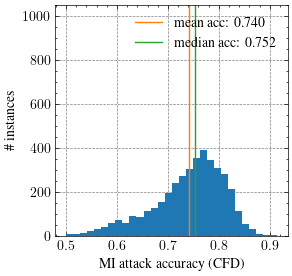

In [92]:
import matplotlib.pyplot as plt
ylims_use = [0,1050]
plt.style.use('figures/matplot.mplstyle')
attack = "CFD"
plt.hist(acc_dict[attack], bins=30)
plt.xlabel(f"MI attack accuracy ({attack})")
plt.ylabel(r"\# instances")
plt.plot([np.mean(acc_dict[attack]), np.mean(acc_dict[attack])], [ylims_use[0], ylims_use[1]], label=f"mean acc: {np.mean(acc_dict[attack]):.3f}")
plt.plot([np.median(acc_dict[attack]), np.median(acc_dict[attack])], [ylims_use[0], ylims_use[1]], label=f"median acc: {np.median(acc_dict[attack]):.3f}")
print(np.median(acc_dict[attack]))
plt.ylim(ylims_use)
plt.legend()
plt.gcf().set_size_inches(3,3)
plt.gcf().savefig(f"figures/distribution_{dset}_{attack}.pdf")

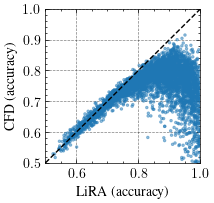

In [49]:
#from matplotlib.markers import MarkerStyle
import matplotlib
#mymarker = matplotlib.markers.MarkerStyle("o", fillstyle="none"), 
import matplotlib.pyplot as plt
x1=  "Loss"
x2 = "CFD"
plt.style.use('figures/matplot.mplstyle')
plt.scatter(acc_dict[x1], acc_dict[x2], 2, alpha=0.6, marker="o")
plt.xlabel(f"{x1 if x1!='Loss' else 'LiRA'} (accuracy)")
plt.ylabel(f"{x2} (accuracy)")
plt.plot([0.5, 1.0], [0.5,1.0], "--k")
plt.xlim([0.5,1.0])
plt.ylim([0.5,1.0])
plt.gcf().set_size_inches(2,2)
plt.gcf().savefig(f"figures/scatter_{dset}_{x1}{x2}.pdf")

In [189]:
fs = np.linspace(0,1,100)
fs_log = np.exp(np.linspace(-12, 0, 100))
from scipy import interpolate
from sklearn.metrics import roc_curve
def interpolate_tprs(fprs, stats_lists, sign=-1):
    ts_rates = []
    for run in stats_lists:
        fs, ts, thresholds = roc_curve(run[1], sign*run[0], pos_label=1)
        f = interpolate.interp1d(fs, ts, fill_value=0)
        ts_rates.append(f(fprs))
    ts_rates = np.stack(ts_rates)
    return ts_rates

In [197]:
## Interpolate and plot TPR/FPR curves
import numpy as np
from sklearn.metrics import roc_curve
import torch

dset = "cifar"
attack_files = [("CFD", f"mi_scores_cfd_{dset}.pt"), ("Loss", f"mi_scores_loss_{dset}.pt"), ("GLiR", f"mi_scores_glir_{dset}.pt")]
tpr_dict, tpr_dict_log = {}, {}
for attk_name, filename in attack_files:
    if os.path.exists(attack_path + "/" + filename):
        mi_score_array, mi_labels_array = torch.load(attack_path + "/" + filename)
        total_train_pts=mi_score_array.shape[1]
        print("Evaluating", attk_name)
        stats_list = []
        for i in range(len(mi_score_array)):
            stats_list.append((mi_score_array[i], mi_labels_array[i]))
        tpr_dict[attk_name] = interpolate_tprs(fs, stats_list, 1 if attk_name == "CFD" else -1)
        tpr_dict_log[attk_name] = interpolate_tprs(fs_log, stats_list, 1 if attk_name == "CFD" else -1)    
    #tpr_dict[attk_name], acc_dict[attk_name] = tprat01, maxacc

Evaluating CFD
Evaluating Loss
Evaluating GLiR


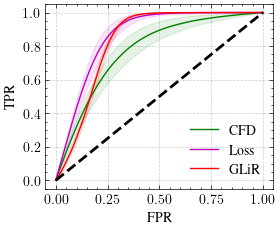

In [198]:
#ts_rates_all = torch.load("figures/grad_attack_rates1.pt")
fs_use = fs
fs = np.linspace(0,1,100)
plt.style.use('figures/matplot.mplstyle')
colors = ["g", "m", "r", "b"]
for setup_use, color_use in zip(tpr_dict.keys(), colors):
    mean_rnd = np.mean(tpr_dict[setup_use], axis=0)
    mean_rnd_std = np.std(tpr_dict[setup_use], axis=0) # Standard error
    plt.fill_between(fs_use, mean_rnd-mean_rnd_std, mean_rnd+mean_rnd_std, color=color_use, alpha = 0.1)
    plt.plot(fs_use, mean_rnd, label = f"{setup_use}", color=color_use)  

plt.plot(fs_use, fs_use, "--k", linewidth=2)

#plt.plot(fs_use, analytical_tpr(fs_use, 2.54), "--", color="tab:blue", label = "analytical\n($\mu=2.54$)", linewidth=2)
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend(loc="lower right")
plt.grid(color='0.6')
plt.gcf().set_size_inches(3.0, 2.5)
plt.tight_layout()
plt.gcf().savefig(f"success_{dset}.pdf")

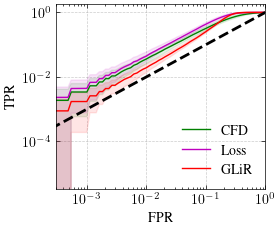

In [199]:
#ts_rates_all = torch.load("figures/grad_attack_rates1.pt")
fs_use = fs_log
colors = ["g", "m", "r", "b"]
for setup_use, color_use in zip(tpr_dict_log.keys(), colors):
    mean_rnd = np.mean(tpr_dict_log[setup_use], axis=0)
    mean_rnd_std = np.std(tpr_dict_log[setup_use], axis=0) # Standard error
    plt.fill_between(fs_use, mean_rnd-mean_rnd_std, mean_rnd+mean_rnd_std, color=color_use, alpha = 0.1)
    plt.loglog(fs_use, mean_rnd, label = f"{setup_use}", color=color_use)  

plt.plot(fs_use, fs_use, "--k", linewidth=2)
plt.xlim([3e-4, 1])
#plt.plot(fs_use, analytical_tpr(fs_use, 2.54), "--", color="tab:blue", label = "analytical\n($\mu=2.54$)", linewidth=2)
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend(loc="lower right")
plt.grid(color='0.6')
plt.gcf().set_size_inches(3.0, 2.5)
plt.tight_layout()
plt.gcf().savefig(f"success_{dset}_log.pdf")

In [206]:
## Shadow model eval. We compute quantiles (aka. ranks).
## Interpolate and plot TPR/FPR curves
import numpy as np
from sklearn.metrics import roc_curve
import torch

dset = "cancer"
attack_files = [("CFD", f"mi_scores_cfd_{dset}.pt"), ("LiRA", f"mi_scores_loss_{dset}.pt"), ("GLiR", f"mi_scores_glir_{dset}.pt")]
attack_path = "results"
tpr_dict, tpr_dict_log = {}, {}
for attk_name, filename in attack_files:
    if os.path.exists(attack_path + "/" + filename):
        mi_score_array, mi_labels_array = torch.load(attack_path + "/" + filename)
        mi_score_array = mi_score_array.argsort(dim=0).argsort(dim=0)
        total_train_pts=mi_score_array.shape[1]
        print("Evaluating", attk_name)
        stats_list = []
        for i in range(len(mi_score_array)):
            stats_list.append((mi_score_array[i], mi_labels_array[i]))
        tpr_dict[attk_name] = interpolate_tprs(fs, stats_list, 1 if attk_name == "CFD" else -1)
        tpr_dict_log[attk_name] = interpolate_tprs(fs_log, stats_list, 1 if attk_name == "CFD" else -1)    
    #tpr_dict[attk_name], acc_dict[attk_name] = tprat01, maxacc

Evaluating CFD
Evaluating LiRA
Evaluating GLiR


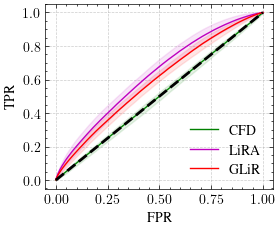

In [207]:
#ts_rates_all = torch.load("figures/grad_attack_rates1.pt")
fs_use = fs
plt.style.use('figures/matplot.mplstyle')
colors = ["g", "m", "r", "b"]
for setup_use, color_use in zip(tpr_dict.keys(), colors):
    mean_rnd = np.mean(tpr_dict[setup_use], axis=0)
    mean_rnd_std = np.std(tpr_dict[setup_use], axis=0) # Standard error
    plt.fill_between(fs_use, mean_rnd-mean_rnd_std, mean_rnd+mean_rnd_std, color=color_use, alpha = 0.1)
    plt.plot(fs_use, mean_rnd, label = f"{setup_use}", color=color_use)  

plt.plot(fs_use, fs_use, "--k", linewidth=2)

#plt.plot(fs_use, analytical_tpr(fs_use, 2.54), "--", color="tab:blue", label = "analytical\n($\mu=2.54$)", linewidth=2)
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend(loc="lower right")
plt.grid(color='0.6')
plt.gcf().set_size_inches(3.0, 2.5)
plt.tight_layout()
plt.gcf().savefig(f"figures/success_recalibrated_{dset}.pdf")

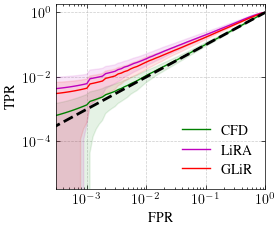

In [208]:
#ts_rates_all = torch.load("figures/grad_attack_rates1.pt")
fs_use = fs_log
colors = ["g", "m", "r", "b"]
for setup_use, color_use in zip(tpr_dict_log.keys(), colors):
    mean_rnd = np.mean(tpr_dict_log[setup_use], axis=0)
    mean_rnd_std = np.std(tpr_dict_log[setup_use], axis=0) # Standard error
    plt.fill_between(fs_use, mean_rnd-mean_rnd_std, mean_rnd+mean_rnd_std, color=color_use, alpha = 0.1)
    plt.loglog(fs_use, mean_rnd, label = f"{setup_use}", color=color_use)  

plt.plot(fs_use, fs_use, "--k", linewidth=2)
plt.xlim([3e-4, 1])
#plt.plot(fs_use, analytical_tpr(fs_use, 2.54), "--", color="tab:blue", label = "analytical\n($\mu=2.54$)", linewidth=2)
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend(loc="lower right")
plt.grid(color='0.6')
plt.gcf().set_size_inches(3.0, 2.5)
plt.tight_layout()
plt.gcf().savefig(f"figures/success_recalibrated_{dset}_log.pdf")

In [188]:
#ts_rates_all = torch.load("figures/grad_attack_rates1.pt")
fs_use = fs_log
colors = ["g", "m", "r", "b"]
for setup_use, color_use in zip(tpr_dict_log.keys(), colors):
    mean_rnd = np.mean(tpr_dict_log[setup_use], axis=0)
    mean_rnd_std = np.std(tpr_dict_log[setup_use], axis=0) # Standard error
    plt.fill_between(fs_use, mean_rnd-mean_rnd_std, mean_rnd+mean_rnd_std, color=color_use, alpha = 0.1)
    plt.loglog(fs_use, mean_rnd, label = f"{setup_use}", color=color_use)  

plt.plot(fs_use, fs_use, "--k", linewidth=2)
plt.xlim([3e-4, 1])
#plt.plot(fs_use, analytical_tpr(fs_use, 2.54), "--", color="tab:blue", label = "analytical\n($\mu=2.54$)", linewidth=2)
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend(loc="lower right")
plt.grid(color='0.6')
plt.gcf().set_size_inches(4.0,3.0)
plt.tight_layout()

NameError: name 'fs_log' is not defined

## How many models required for successful risk prediction

We investigate how many model are required for a stable loss prediction. Use loss for subsequently more out models.

In [286]:
import numpy as np
from sklearn.metrics import roc_curve
import torch
import os
dset = "cifar"
attack_files = [("CFD", f"mi_scores_cfd_{dset}.pt"), ("Loss", f"mi_scores_loss_{dset}.pt"), ("GLiR", f"mi_scores_glir_{dset}.pt"), ("DataAug", f"mi_scores_dataaug_{dset}.pt")]
attack_path = "results"
tpr_dict, acc_dict = {}, {}
for attk_name, filename in attack_files:
    if os.path.exists(attack_path + "/" + filename):
        print("Evaluating", attk_name)
        mi_score_array, mi_labels_array = torch.load(attack_path + "/" + filename)
        total_train_pts=mi_score_array.shape[1]
        mus = np.zeros(total_train_pts)
        maxacc = np.zeros(total_train_pts)
        tprat01 = np.zeros(total_train_pts)
        for instance_no in range(total_train_pts):
            mi_labels = mi_labels_array[:, instance_no]
            mi_losses = mi_score_array[:, instance_no]
            fpr_var, tpr_var, thres = roc_curve(mi_labels, (1 if attk_name in ["CFD", "DataAug"] else -1)*mi_losses)
            # Find largest threshold
            tprat01[instance_no] = np.max(tpr_var[fpr_var < 0.1])
            maxacc[instance_no], mus[instance_no] = compute_maxacc_mu(fpr_var, tpr_var)
        tpr_dict[attk_name], acc_dict[attk_name] = tprat01, maxacc

Evaluating CFD
Evaluating Loss
Evaluating GLiR
Evaluating DataAug


In [211]:
import torch

In [212]:
score_files = f"features_{dset}.pt"
attack_path = "results"
res = torch.load(attack_path + "/" + score_files)
num_out = [1, 3, 5, 10, 20, 50]
key = "loss"
mi_scores, mi_labels = res[key][0][1]
#is_out = 1-mi_labels

## Count the number of out models.
out_arr_list = []
for i in range(mi_scores.shape[1]):
    out_arr_list.append(mi_scores[mi_labels[:, i]==0, i])

score_mean_dict = {}

for j in num_out:
    score_mean_dict[j] = list([r[:j].mean() for r in out_arr_list])

In [213]:
res.keys()

dict_keys(['confidence', 'loss', 'input_grad', 'curvature', 'mahalanobis', 'grad'])

In [217]:
from eval_predictions import compute_metrics
rf_scores = {}
for k_attc, v_attc in acc_dict.items():
    rf_scores[k_attc] = []
    for k, v in score_mean_dict.items():
        cat_list = torch.stack(v, dim=0)
        rf_scores[k_attc].append(compute_metrics(["rf_score"], cat_list, torch.from_numpy(v_attc).float()))

In [218]:
rf_scores

{'CFD': [{'rf_score': 0.05083499953870929},
  {'rf_score': 0.05899937315473891},
  {'rf_score': 0.05225753774986397},
  {'rf_score': 0.057436759785983615},
  {'rf_score': 0.056843851769786236},
  {'rf_score': 0.058003715355041785}],
 'Loss': [{'rf_score': 0.6894921728925579},
  {'rf_score': 0.7778656897150695},
  {'rf_score': 0.7948534021423324},
  {'rf_score': 0.8063985349819671},
  {'rf_score': 0.8198730840106696},
  {'rf_score': 0.8224417141195381}],
 'GLiR': [{'rf_score': 0.4007092494563246},
  {'rf_score': 0.4236050465780977},
  {'rf_score': 0.43996089897940527},
  {'rf_score': 0.44344560937942346},
  {'rf_score': 0.45093504932780737},
  {'rf_score': 0.45109766274725793}]}

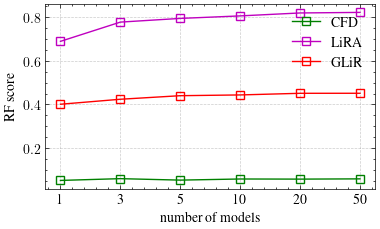

In [219]:
import matplotlib.pyplot as plt
colors = ["g", "m", "r", "b"]

for key, clr in zip(["CFD", "Loss", "GLiR"], colors):
    plt.plot(np.arange(len(num_out)), list([it["rf_score"] for it in rf_scores[key]]), marker="s", c=clr, label=(key if key!= "Loss" else "LiRA"))
plt.xticks(np.arange(len(num_out)), num_out)
plt.xlabel("number of models")
plt.ylabel("RF score")
plt.legend()
plt.grid(color='0.6')
plt.gcf().set_size_inches(4.0, 2.5)
plt.tight_layout()
plt.gcf().savefig(f"figures/num_models_{dset}.pdf")

## Print nice table with results

Code to produce the main table.

In [252]:
dset = "cancer"
score_files = [("CFD", f"results/predict_mi_scores_cfd_{dset}.json"), ("LiRA", f"results/predict_mi_scores_loss_{dset}.json"), ("GLiR", f"results/predict_mi_scores_glir_{dset}.json")]
score_used = "rf_score"
hyperconfig = {"mahalanobis": 0} ## which hyperparameter run to use

In [253]:
from collections import defaultdict
import json
res_dict = defaultdict(list)
for attack, score_file in score_files:
    results = json.load(open(score_file))
    for key, values in results.items():
        print(key)
        if key in hyperconfig:
            results_method = values[hyperconfig[key]][1]
        else:  
            results_method = values[0][1]
        if "in_"+score_used in results_method:
            res_dict[key + " (in)"].append(results_method["in_"+score_used])
            res_dict[key + " (out)"].append(results_method["out_"+score_used])
            res_dict[key + " (all)"].append(results_method["all_"+score_used])
        else:
            res_dict[key].append(results_method[score_used])
            

loss
confidence
input_grad
curvature
mahalanobis
grad
shap
loss
confidence
input_grad
curvature
mahalanobis
grad
shap
confidence
loss
input_grad
curvature
mahalanobis
grad
shap


In [254]:
for k, v in res_dict.items():
    formatted = list([f"{s:.2f}" for s in v])
    str = f"{k.replace('_', '-')} & {' & '.join(formatted)} \\\\"
    print(str)

loss (in) & 0.06 & 0.72 & 0.42 \\
loss (out) & 0.07 & 0.82 & 0.45 \\
loss (all) & 0.06 & 0.79 & 0.44 \\
confidence (in) & 0.06 & 0.60 & 0.39 \\
confidence (out) & 0.07 & 0.52 & 0.37 \\
confidence (all) & 0.05 & 0.57 & 0.39 \\
input-grad (in) & 0.00 & 0.04 & 0.01 \\
input-grad (out) & 0.01 & 0.11 & 0.06 \\
input-grad (all) & 0.00 & 0.07 & 0.03 \\
curvature (in) & 0.06 & 0.63 & 0.40 \\
curvature (out) & 0.05 & 0.69 & 0.46 \\
curvature (all) & 0.06 & 0.68 & 0.45 \\
mahalanobis & 0.05 & 0.19 & 0.14 \\
grad (in) & 0.06 & 0.69 & 0.41 \\
grad (out) & 0.05 & 0.78 & 0.48 \\
grad (all) & 0.05 & 0.76 & 0.46 \\
shap (in) & 0.06 & 0.18 & 0.20 \\
shap (out) & 0.07 & 0.18 & 0.21 \\
shap (all) & 0.06 & 0.19 & 0.21 \\


In [301]:
dset="cifar"
score_files = f"features_{dset}.pt"
attack_path = "results"

res = torch.load(attack_path + "/" + score_files)
num_out = [1, 3, 5, 10, 20, 50]
method_keys_list = ["mahalanobis", "vae_reconstruction_loss", "loss", "confidence", "shap", "curvature", "grad", "input_grad"]

#is_out = 1-mi_labels
res_dict = {}
for method_key in method_keys_list:
    ## Count the number of out models.
    if method_key in ["mahalanobis", "vae_reconstruction_loss"]:
        all_data = res[method_key][0][1]
        res_dict[method_key] = all_data
    else:
        mi_scores, mi_labels = res[method_key][0][1]
        data = mi_scores
        print("recalibrate")
        labels = mi_labels
        in_data = data.clone()
        out_data = data.clone()
        in_data[labels==0] = 0
        out_data[labels==1] = 0
        in_data = in_data.sum(axis=0)/labels.sum(axis=0)
        out_data = out_data.sum(axis=0)/(1-labels).sum(axis=0)
        all_data = data.mean(axis=0)
        #res_dict[method_key+ "_a"] = all_data
        #res_dict[method_key+ "_i"] = in_data
        res_dict[method_key+ "_o"] = out_data

## 
for k in res_dict:
    res_dict[k] = (res_dict[k]-torch.mean(res_dict[k]))/torch.std(res_dict[k])

recalibrate
recalibrate
recalibrate
recalibrate
recalibrate
recalibrate


In [302]:
res_dict.keys()

dict_keys(['mahalanobis', 'vae_reconstruction_loss', 'loss_o', 'confidence_o', 'shap_o', 'curvature_o', 'grad_o', 'input_grad_o'])

In [303]:
import pandas as pd
mydf = pd.DataFrame(res_dict)

In [304]:
mydf

,mahalanobis,vae_reconstruction_loss,loss_o,confidence_o,shap_o,curvature_o,grad_o,input_grad_o
0,0.185121,0.336960,0.266127,-1.007175,0.667797,0.453745,2.277991,1.360186
1,1.419567,2.409493,-0.299898,-0.816612,0.915968,-0.491313,0.176892,-0.380408
2,-0.126698,-0.302795,-1.286164,1.373707,-0.011152,-0.823381,-1.721230,-1.093872
3,-0.768964,-1.063986,-0.077795,0.044797,-0.805111,0.178976,0.419672,0.682539
4,0.494774,0.182537,0.640007,-0.301570,-0.559469,-0.360912,0.619987,-0.260337
...,...,...,...,...,...,...,...,...
3995,-0.952261,-0.943907,-0.529036,-0.839879,-0.049674,1.456138,0.178971,0.055202
3996,0.622812,0.200196,0.156413,-0.500044,0.190798,0.198217,0.610491,0.339879
3997,-0.930951,-1.157363,0.443165,-0.902367,0.171962,0.822242,1.018854,0.694910
3998,-0.994250,-0.850998,0.412073,-0.334810,0.683077,-0.272020,0.508651,-0.422974


In [305]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [319]:
myLR = LinearRegression() #Ridge(penalty="l2")
attk = "CFD"
myLR.fit(mydf.values, acc_dict[attk])

LinearRegression()

In [320]:
print(" & ".join([f"{x:.3f}" for x in myLR.coef_]))

0.000 & 0.007 & -0.022 & -0.046 & 0.004 & -0.006 & 0.009 & 0.016


In [321]:
myLR.score(mydf.values, acc_dict[attk])

0.5844198467047085

In [287]:
acc_dict.keys()

dict_keys(['CFD', 'Loss', 'GLiR', 'DataAug'])

In [255]:
import torch
results = torch.load("results/features_cifar.pt")

In [269]:
results["mahalanobis"][0][1]

tensor([357.2812, 572.0073, 303.0417,  ..., 163.1457, 152.1351, 383.6030])

In [84]:
results.keys()

dict_keys(['curvature', 'loss', 'vae_reconstruction_loss', 'mahalanobis', 'shap'])

In [22]:
print(list([k[0] for k in results["vae_reconstruction_loss"]]))

[{}]


In [23]:
rec_loss = results["vae_reconstruction_loss"][0][1]

In [24]:
len(results["vae_reconstruction_loss"])

1

In [25]:
data, method_values = results["curvature"][9]

In [26]:
data

{'n_samples': 20, 'eps': 0.0001}

In [27]:
data = method_values[0]
labels = method_values[1]
in_data = data.clone()
out_data = data.clone()
in_data[labels==0] = 0
out_data[labels==1] = 0
in_data = in_data.sum(axis=0)/labels.sum(axis=0)
out_data = out_data.sum(axis=0)/(1-labels).sum(axis=0)

Text(0, 0.5, 'curvature')

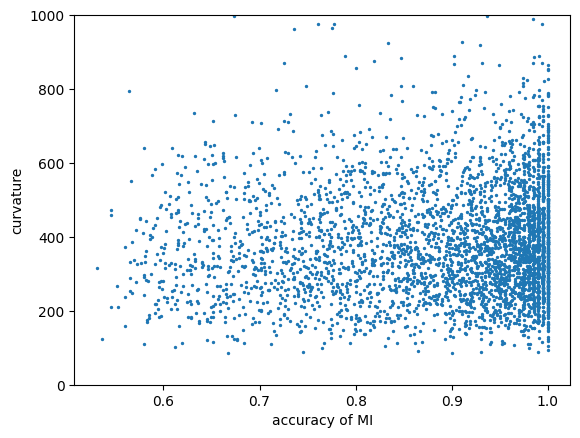

In [28]:
import matplotlib.pyplot as plt
plt.scatter(maxacc, rec_loss, 2)
plt.ylim([0, 1000])
plt.xlabel("accuracy of MI")
plt.ylabel("curvature")

0.8906059795349331
0.9347913121809629


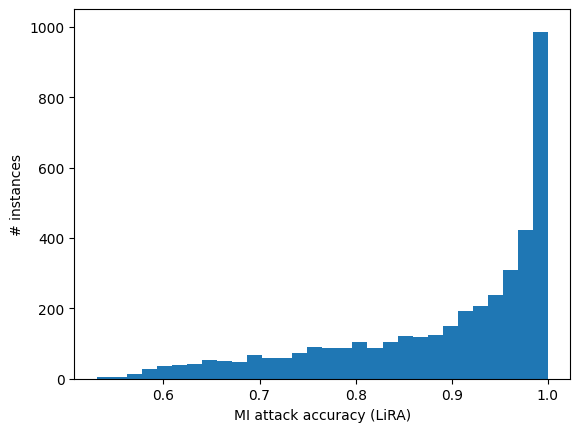

In [29]:
plt.hist(maxacc, bins=30)
plt.xlabel("MI attack accuracy (LiRA)")
plt.ylabel("# instances")
plt.ylim([0,1050])
print(np.mean(maxacc))
print(np.median(maxacc))

In [28]:
torch.mean(ret_list_var)

tensor(nan, dtype=torch.float16)

In [21]:
## Find highest-acc attack.
import numpy as np
def compute_best_acc(ret_list):
    fpr_var, tpr_var, thres = sklearn.metrics.roc_curve(1-mi_labels, ret_list)
    acc = 0.5*(tpr_var + (1-fpr_var))
    return np.max(acc)

In [22]:
compute_best_acc(ret_list)

0.611

In [23]:
n_sample = 100000
id_cnt = 0
check_list = [0, 1, 2, 3, 4]
for pid, p in enumerate(model_opacus.parameters()):
    if pid < 30:
        lacc = []
        idx_test = torch.randperm(p.numel())[:n_sample]
        for k in idx_test:
            lacc.append(compute_best_acc(ret_list_var[:,id_cnt+k]))
        lacc = np.array(lacc)
        print(pid, p.shape, np.max(lacc), np.mean(lacc), np.min(lacc))
        id_cnt += p.numel()

0 torch.Size([64, 3, 7, 7]) 0.627 0.6160380527210884 0.607
1 torch.Size([64]) 0.621 0.6147968749999999 0.595
2 torch.Size([64]) 0.625 0.61509375 0.594
3 torch.Size([64, 64, 3, 3]) 0.626 0.6130051812065971 0.577
4 torch.Size([64]) 0.622 0.614328125 0.597
5 torch.Size([64]) 0.622 0.6149843749999999 0.596
6 torch.Size([64, 64, 3, 3]) 0.628 0.6112833116319444 0.564
7 torch.Size([64]) 0.622 0.615765625 0.609
8 torch.Size([64]) 0.622 0.61615625 0.612
9 torch.Size([64, 64, 3, 3]) 0.627 0.6137749565972223 0.592
10 torch.Size([64]) 0.623 0.616296875 0.607
11 torch.Size([64]) 0.621 0.61659375 0.612
12 torch.Size([64, 64, 3, 3]) 0.627 0.6130441080729166 0.587
13 torch.Size([64]) 0.623 0.616359375 0.612
14 torch.Size([64]) 0.624 0.616859375 0.613
15 torch.Size([128, 64, 3, 3]) 0.628 0.612201917860243 0.583
16 torch.Size([128]) 0.623 0.6128046875 0.592
17 torch.Size([128]) 0.624 0.6128515625 0.593


KeyboardInterrupt: 

In [ ]:
lidx = []
lacc = []

for i in tqdm(range(0, int(1e6))):
    lidx.append(i)
    lacc.append(compute_best_acc(ret_list_var[:,i]))
lacc = np.array(lacc)


In [35]:
np.max(lacc)

0.635

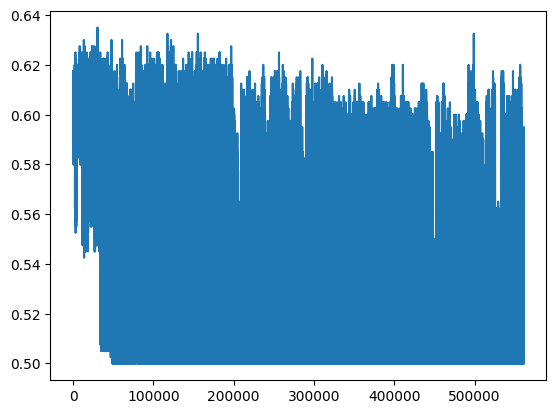

In [36]:
plt.plot(lacc)

In [23]:
torch.max(ret_list_var[:,:9408].mean(dim=1))

tensor(inf, dtype=torch.float16)

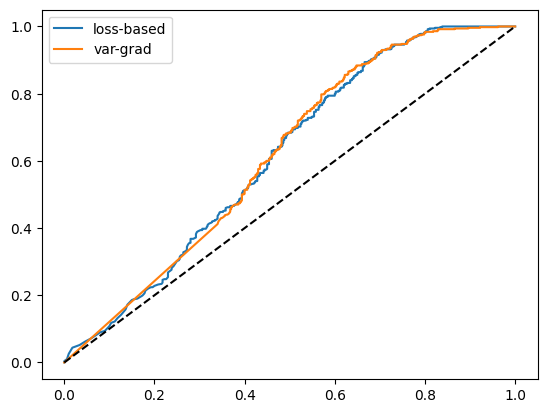

In [29]:
ret_list_var_mean = ret_list_var[:,:9408].float().mean(dim=1)
fpr_var, tpr_var, thres = sklearn.metrics.roc_curve(mi_labels, -ret_list_var_mean)
plt.plot(fpr, tpr, label="loss-based")
plt.plot(fpr_var, tpr_var, label="var-grad")
plt.plot([0,1], [0,1], "--k")
plt.legend()

In [62]:
factor = ret_list_var.mean()/ret_list.mean()

In [30]:
fpr_var, tpr_var, thres = sklearn.metrics.roc_curve(1-mi_labels, factor*ret_list + ret_list_var)
plt.lg(fpr, tpr, label="loss-based")
plt.plot(fpr_var, tpr_var, label="var-grad")
plt.plot([0,1], [0,1], "--k")
plt.legend()

NameError: name 'factor' is not defined

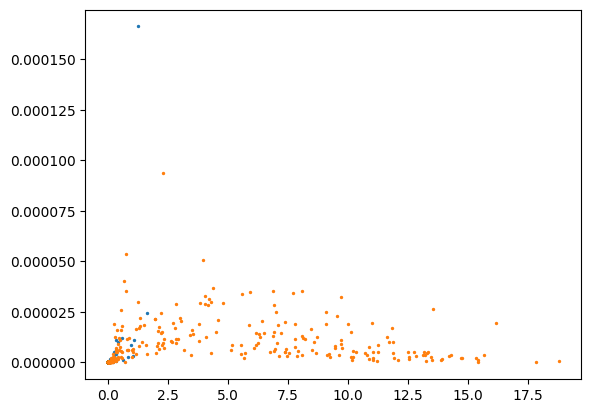

In [225]:
plt.scatter(ret_list[:n_use], ret_list_var[:n_use], 2)
plt.scatter(ret_list[n_use:], ret_list_var[n_use:], 2)

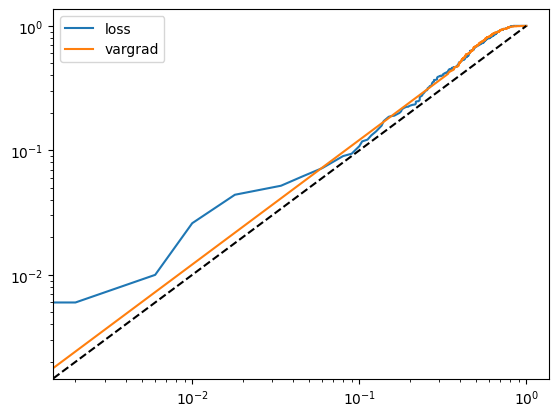

In [31]:
plt.loglog(fpr, tpr, label="loss")
plt.loglog(fpr_var, tpr_var, label="vargrad")
plt.loglog([0,1], [0,1], "--k")
plt.legend()

## Parameter perturbation attack

In [188]:
def compute_loss_perturbations(n_samples = 25, sigma= 0.001):
    """ Compute perturbations of the loss. """
    listdl = ListDataLoader(base_trainloader, base_testloader)
    criterion = nn.CrossEntropyLoss(reduction="none").to(device)
    print("Compute initial model.")
    model_opacus = get_model()
    org_loss = compute_loss(model_opacus, listdl, criterion).cpu()
    sample_list = []
    for i in range(n_samples):
        model_opacus = get_model()
        ## Perturb model
        for p in model_opacus.parameters():
            p.data = p.data + sigma*torch.randn_like(p.data)
        ret_list = compute_loss(model_opacus, listdl, criterion).cpu()
        sample_list.append(ret_list-org_loss)
    return torch.stack(sample_list)

In [199]:
mope_scores = compute_loss_perturbations(n_samples = 20, sigma= 0.008)

Compute initial model.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 43.49it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 30.63it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 35.46it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 40.09it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 32.58it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 38.32it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 48.30it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 39.33it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 42.25it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 45.12it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 43.32it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 36.14it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.24it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 47.09it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.45it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 37.65it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 39.10it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 34.28it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 37.20it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 34.70it/s]

ListDataLoader exhausted



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.81it/s]

ListDataLoader exhausted


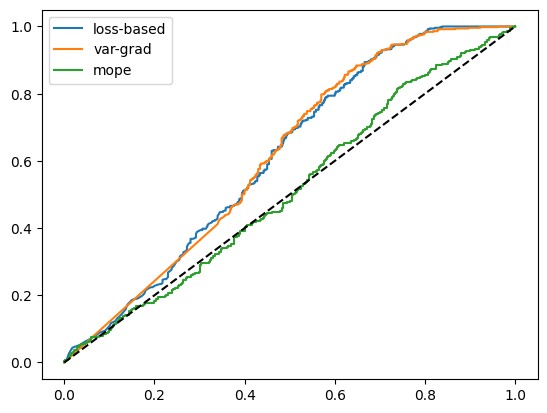

In [203]:
fpr_mope, tpr_mope, thres = sklearn.metrics.roc_curve(mi_labels, -mope_scores)

plt.plot(fpr, tpr, label="loss-based")
plt.plot(fpr_var, tpr_var, label="var-grad")
plt.plot(fpr_mope, tpr_mope, label="mope")
plt.plot([0,1], [0,1], "--k")
plt.legend()

Text(0, 0.5, 'TPR')

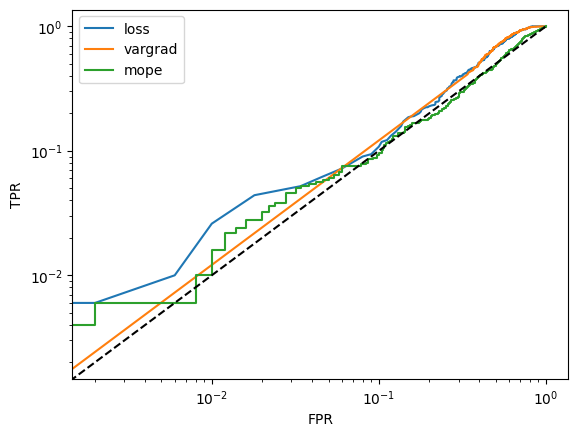

In [204]:
plt.loglog(fpr, tpr, label="loss")
plt.loglog(fpr_var, tpr_var, label="vargrad")
plt.loglog(fpr_mope, tpr_mope, label="mope")
plt.loglog([0,1], [0,1], "--k")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")

In [167]:
from scipy.stats import spearmanr

In [132]:
spearmanr(mope_scores, ret_list)

SignificanceResult(statistic=0.9936282327155865, pvalue=0.0)

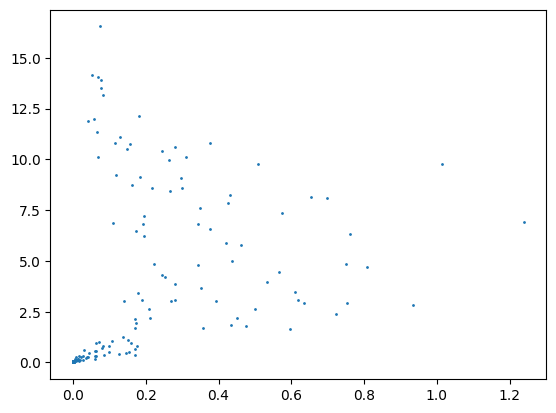

In [134]:
plt.scatter(mope_scores, ret_list, 1)

## Can we use local explanations to predict membership Inference Risk?

Intuition: The model / loss landscape around instances behaves differently according to the MI risk.

In [32]:
from vae_model import VAE
import torch
res = torch.load("vae_checkpoints/checkpoint.pth.tar", map_location="cuda:3")

In [33]:
res["epoch"]

300

In [19]:
myvae = VAE()
device = "cuda:3"
myvae.load_state_dict(res["state_dict"])
myvae = myvae.to(device)

In [14]:
import torchvision.transforms as transforms
import torchvision
from dp_sgd import RandomSubsetDataset
n_eval_points=4000
batch_size = 32
transform_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))])
cifar_train = torchvision.datasets.CIFAR10(root = ".", train=True, download=True, transform=transform_test)
cifar_test = torchvision.datasets.CIFAR10(root = ".", train=False, download=True, transform=transform_test)
assess_dataset = RandomSubsetDataset(cifar_train, subsample_ratio=1.0, n_use_total=n_eval_points)
assess_dataset.sample_idx = torch.arange(n_eval_points)
#background_loader = torch.utils.data.DataLoader(background_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
assess_loader = torch.utils.data.DataLoader(assess_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified
Using sub dataset of size 4000


In [27]:
import torch.nn as nn

mse_loss = nn.MSELoss(reduction="none")
with torch.no_grad():
    mse_loss_list = []
    for i, (data, _) in enumerate(assess_loader):
        data = data.to(device)
        recon_batch, mu, logvar = myvae(data)
        MSE = mse_loss(recon_batch, data).reshape(len(data), -1)
        mse_loss_list.append(MSE.sum(axis=-1))

In [29]:
all_losses = torch.cat(mse_loss_list)

In [31]:
all_losses.shape

torch.Size([4000])

In [2]:
import torch
(mi_scores, mi_labels) = torch.load("results/mi_scores_glir_imdb.pt")
(mi_scores2, mi_labels2) = torch.load("results/mi_scores_glir_imdb_rest.pt")

In [8]:
mi_scores

tensor([[ -146.0581, -3964.2430, -2850.9373,  ..., -3946.6095, -3289.0920,
         -3983.6314],
        [  -85.5501, -3138.0731, -2967.3381,  ..., -3117.0512,  -125.4402,
         -3195.3030],
        [-1592.2468, -3157.7838,  -124.2228,  ..., -3190.8661, -2314.3945,
         -3288.2959],
        ...,
        [-2811.0356, -3603.9464, -3208.1093,  ..., -3706.2330,  -108.3851,
         -3706.7024],
        [  -93.1189, -3586.1116, -2653.3494,  ..., -3556.6014,  -120.2018,
         -3601.0559],
        [ -160.8372, -3800.9161, -3552.0560,  ..., -3701.9420, -3247.9616,
         -3801.3309]], dtype=torch.float64)

In [10]:
mi_labels2

tensor([[1, 0, 0,  ..., 1, 1, 0],
        [0, 1, 0,  ..., 1, 1, 1],
        [0, 0, 1,  ..., 1, 1, 0],
        ...,
        [1, 1, 1,  ..., 1, 0, 1],
        [1, 1, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 1]])

In [11]:
mi_labels

tensor([[0, 0, 1,  ..., 0, 1, 1],
        [0, 1, 1,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 1, 1],
        ...,
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 1, 1, 0]])

In [12]:
mi_scores = torch.cat((mi_scores, mi_scores2), dim=0)
mi_labels = torch.cat((mi_labels, mi_labels2), dim=0)

In [14]:
mi_labels.shape

torch.Size([200, 4000])

In [15]:
torch.save((mi_scores, mi_labels), "results/mi_scores_glir_imdb.pt")

In [43]:
mi_scores

tensor([[472.1077, 446.0030, 502.4792,  ..., 502.6611, 507.3105, 492.9100],
        [397.5889, 419.6324, 419.8840,  ..., 567.4819, 633.8085, 571.7716],
        [ 85.2155, 588.3927, 575.2114,  ..., 576.1622, 562.8225, 517.8481],
        ...,
        [332.0908, 474.9348, 561.6799,  ..., 593.7234, 428.7890, 304.9310],
        [497.9379, 524.0428, 555.7175,  ..., 602.7435, 473.3535, 368.6142],
        [500.5675, 308.2291, 485.8047,  ..., 579.3583, 461.2812, 303.8450]])

In [17]:
mi_labels.shape

torch.Size([5, 2000])

In [39]:
fs, ts, thresholds = roc_curve(mi_labels[2], -mi_scores[2], pos_label=1)

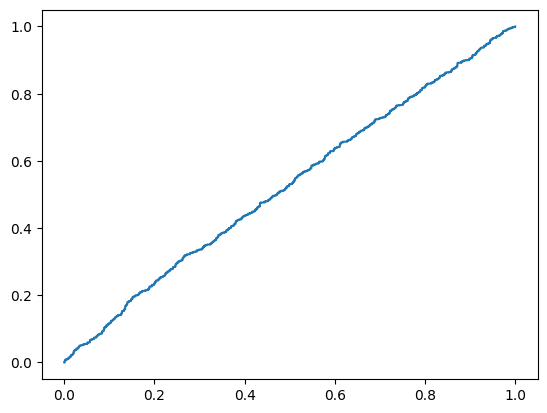

In [40]:
plt.plot(fs, ts)

In [19]:
mi_scores[:5] = mi_scores2
mi_labels[:5] = mi_labels2

In [20]:
(mi_scores[:,0][mi_labels[:,0]==0]).mean()

tensor(0.7173)

In [21]:
mi_labels

tensor([[0, 0, 1,  ..., 0, 1, 1],
        [0, 1, 1,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 0, 1],
        [1, 1, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 1]])

In [22]:
(mi_scores[:,0][mi_labels[:,0]==1]).mean()

tensor(0.6991)

In [25]:
import sklearn
maxacc_arr = []
for mid in range(0, 2000):
    fpr_mope, tpr_mope, thres = sklearn.metrics.roc_curve(mi_labels[:, mid], mi_scores[:, mid])
    maxacc_arr.append(np.max(0.5*(tpr_mope+(1-fpr_mope))))
#print(np.mean(maxacc_arr), maxacc_arr)

In [26]:
plt.scatter(maxacc_arr)

TypeError: scatter() missing 1 required positional argument: 'y'

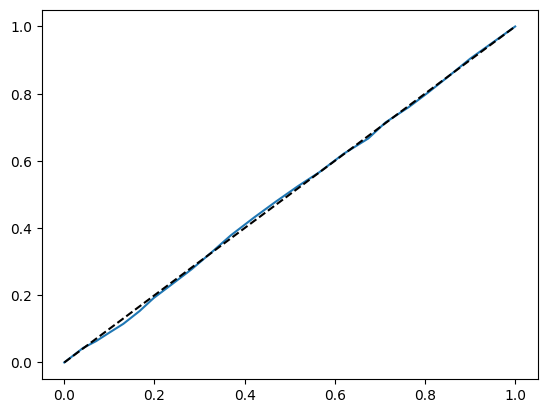

In [217]:
mid=0
fpr_mope, tpr_mope, thres = sklearn.metrics.roc_curve(mi_labels[mid, :], mi_scores[mid, :])
plt.plot(fpr_mope, tpr_mope)
plt.plot([0,1], [0,1], "--k")

0.5335048837239659
0.5307066385080901


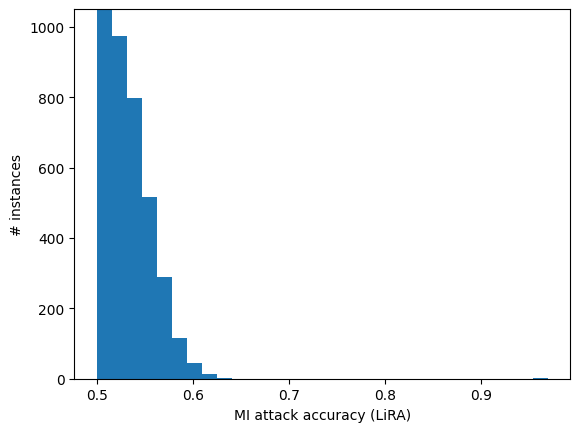

In [27]:
plt.hist(maxacc, bins=30)
plt.xlabel("MI attack accuracy (LiRA)")
plt.ylabel("# instances")
plt.ylim([0,1050])
print(np.mean(maxacc_arr))
print(np.median(maxacc_arr))

In [240]:
scores = torch.load("results/features_cancer.pt")

In [242]:
scores["shap"][0]

[{'n_samples': 1, 'var_use': 0.0, 'agg': 'mean', 'agg_param': 'var'},
 (tensor([[2.7531e-08, 3.3530e-08, 3.9440e-08,  ..., 7.3266e-08, 2.7113e-08,
           2.3149e-08],
          [2.1900e-08, 4.0337e-08, 1.6462e-08,  ..., 4.3488e-08, 1.1078e-08,
           1.3185e-08],
          [9.2537e-09, 6.5353e-09, 2.1119e-08,  ..., 2.6399e-08, 9.6152e-09,
           2.4027e-08],
          ...,
          [2.2590e-08, 3.9750e-08, 5.2467e-08,  ..., 7.5706e-08, 5.0879e-08,
           9.1848e-08],
          [1.0316e-08, 1.5379e-08, 1.7257e-08,  ..., 4.0138e-08, 1.7863e-08,
           8.2111e-09],
          [1.9975e-08, 7.9379e-08, 1.4290e-07,  ..., 6.3083e-08, 8.7663e-08,
           8.0191e-08]]),
  tensor([[0, 1, 0,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 1, 1, 1],
          [1, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 0, 0,  ..., 0, 1, 0],
          [1, 1, 1,  ..., 1, 1, 1],
          [0, 1, 0,  ..., 0, 1, 1]]))]

## Recompute scores.

In [239]:
mi_scores, mi_labels = torch.load("results/features_cancer.pt")

ValueError: too many values to unpack (expected 2)

In [51]:
mi_scores.shape

torch.Size([200, 2000])

In [52]:
mi_scores

tensor([[45.4455, 44.6353, 44.8340,  ..., 44.3625, 41.7444, 67.4241],
        [43.6922, 63.9702, 41.6298,  ..., 42.1968, 43.7099, 39.9293],
        [44.1062, 88.3201, 25.6000,  ..., 65.4131, 59.7253, 40.6408],
        ...,
        [83.4026, 63.1679, 66.9368,  ..., 62.6720, 42.7117, 45.6737],
        [87.3784, 66.7834, 59.6748,  ..., 85.6385, 60.2487, 89.0645],
        [42.9401, 39.2645, 64.7478,  ..., 44.4425, 59.4323, 86.6147]])

In [83]:
mi_scores[mi_labels==1].mean()

tensor(1.1700)

In [102]:
res = torch.load("SkinCancer_Cinf_tau0.0_batch64_ep40_resnet_0.pt")

In [14]:
import torch
res = torch.load("/mnt/ssd3/tobias/mi_auditing/models_trace/imdb_Cinf_tau0.0_batch64_ep8_bert4_0.pt")

In [19]:
import torch
res = torch.load("/mnt/ssd3/tobias/mi_auditing/models_trace/CIFAR10_Cinf_tau0.0_batch32_ep30_resnet_2.pt")

In [28]:
res = list(res["stepwise_params"][0].items())

In [31]:
print(list((v[0], v[1].numel()) for v in res[-10:]))

[('_module.layer4.0.downsample.1.weight', 512), ('_module.layer4.0.downsample.1.bias', 512), ('_module.layer4.1.conv1.weight', 2359296), ('_module.layer4.1.bn1.weight', 512), ('_module.layer4.1.bn1.bias', 512), ('_module.layer4.1.conv2.weight', 2359296), ('_module.layer4.1.bn2.weight', 512), ('_module.layer4.1.bn2.bias', 512), ('_module.fc.weight', 5120), ('_module.fc.bias', 10)]


In [22]:
len(res["stepwise_grads"][0]) 

10

In [25]:
npar = 0
for v in res["stepwise_grads"][0]:
    npar += v.numel()
print(npar)

4726794


In [104]:
train_point_idx_use = res["samples_used"]           
all_samples = torch.zeros(len(res["losses"]))
all_samples[train_point_idx_use]=1 # set the train indices to zero.

In [105]:
res["losses"][all_samples==1].mean()

tensor(0.4578, device='cuda:0')

In [106]:
res["losses"][all_samples==0].mean()

tensor(0.9727, device='cuda:0')

In [107]:
mi_scores

tensor([[0.4313, 3.7673, 0.3906,  ..., 2.1872, 3.4648, 1.7231]])

In [108]:
fpr_var, tpr_var, thres = sklearn.metrics.roc_curve(all_samples.flatten(), -res["losses"].cpu().numpy())

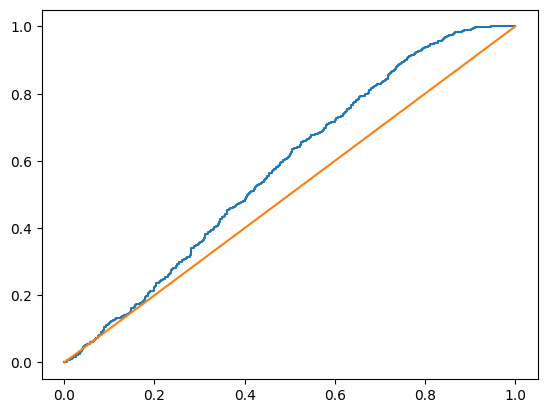

In [109]:
plt.plot(fpr_var, tpr_var)
plt.plot([0,1],[0,1])